## imports

In [25]:
# standard imports
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt 
import datetime

# some mapping widgets
import ipyleaflet
from ipyleaflet import Map, GeoData, Rectangle, basemaps, LayersControl, basemap_to_tiles, TileLayer, SplitMapControl, Polygon, MagnifyingGlass
import ipywidgets

# database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas, raster_to_rasterio
from snowexsql.db import get_table_attributes

from sqlalchemy.sql import func
from geoalchemy2.types import Raster

import ipyleaflet
from ipyleaflet import Map, Rectangle, basemaps, basemap_to_tiles, TileLayer, SplitMapControl, Polygon
from ipyleaflet import GeoData, LayersControl

import numpy as np
import pandas as pd

from rasterio.plot import show
import shapely.geometry

from geoalchemy2.shape import from_shape
import geoalchemy2.functions as gfunc
import rioxarray
import rasterio

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats


In [26]:
# load the database
db_name = 'snow:hackweek@db.snowexdata.org/snowex'
engine, session = get_db(db_name)

print('SnowEx Database successfully loaded!')

SnowEx Database successfully loaded!


In [27]:
# How to read the ~350 MB csv file of GPR points (2-way travel time) + ASO depths/SWE/pixel centers
df= pd.read_csv("GPR_AND_ASO_ALL_FIXED.csv")
gdf = gpd.GeoDataFrame(df)
gdf.geometry = gpd.points_from_xy(gdf["easting"], gdf["northing"]) # set to GPR x,y right now
print(gdf.dtypes) # check that floats are floats
gdf.head(10000).plot() # should see spiral

KeyboardInterrupt: 

In [4]:
gdf.head(10000).groupby("ASO_2020_02_02_SWE").count()

,Unnamed: 0,easting,northing,twt,date,geometry,ASO_IDX,ASO_X,ASO_Y,ASO_2020_02_02_SD,ASO_2020_02_13_SD,ASO_2020_02_13_SWE
ASO_2020_02_02_SWE,,,,,,,,,,,,
0.217590,188,188,188,188,188,188,188,188,188,188,188,188
0.230292,1673,1673,1673,1673,1673,1673,1673,1673,1673,1673,1673,1673
0.238773,2093,2093,2093,2093,2093,2093,2093,2093,2093,2093,2093,2093
0.255418,1073,1073,1073,1073,1073,1073,1073,1073,1073,1073,1073,1073
0.258322,461,461,461,461,461,461,461,461,461,461,461,461
0.265839,755,755,755,755,755,755,755,755,755,755,755,755
0.269165,1973,1973,1973,1973,1973,1973,1973,1973,1973,1973,1973,1973
0.274207,1516,1516,1516,1516,1516,1516,1516,1516,1516,1516,1516,1516
0.277877,220,220,220,220,220,220,220,220,220,220,220,220


In [3]:
gdf.groupby("ASO_IDX").count().max()

Unnamed: 0            1316
easting               1316
northing              1316
twt                   1316
date                  1316
geometry              1316
ASO_X                 1316
ASO_Y                 1316
ASO_2020_02_02_SD     1316
ASO_2020_02_13_SD     1316
ASO_2020_02_02_SWE    1316
ASO_2020_02_13_SWE    1316
dtype: int64

In [37]:
gdf_flight1 = gpd.read_file("GPRLiDAR1.csv")

In [38]:
gdf_flight1.head()

,ASO_IDX,twt,ASO_X,ASO_Y,ASO_2020_02_02_SD,ASO_2020_02_02_SWE,date,v,e,dens,SWE,ASO_2020_02_02_dens,geometry
0,"x_idx=0,y_idx=335",8.27,743005.5000015585,4324999.499887459,1.0261328220367432,0.2204099148511886,2020-01-30 00:00:00.000000000,0.24815787715519788,1.4614581339419566,246.23022844610244,0.2526649191861511,465.5565620673391,None
1,"x_idx=0,y_idx=336",8.27,743008.5000015585,4324999.499887459,0.9895117282867432,0.2204099148511886,2020-01-30 00:00:00.000000000,0.2393015062362136,1.5716348303985042,246.23022844610244,0.24364769890614243,448.941568238806,None
2,"x_idx=0,y_idx=338",5.59,743014.5000015585,4324999.499887459,0.7722265720367432,0.2204099148511886,2020-01-30 00:00:00.000000000,0.2762885767573321,1.1790077258367744,268.332882461998,0.20721378198836704,350.3592715228431,None
3,"x_idx=0,y_idx=339",6.41,743017.5000015585,4324999.499887459,0.8462011814117432,0.2204099148511886,2020-01-30 00:00:00.000000000,0.2640253296136484,1.2910745565606923,268.332882461998,0.2270636021509611,383.9215590564799,None
4,"x_idx=0,y_idx=351",5.0,743053.5000015586,4324999.499887459,0.6357519626617432,0.2101852297782898,2020-01-30 00:00:00.000000000,0.2543007850646973,1.3917047438998105,251.33817354060923,0.15978873712026012,302.47223524333987,None


In [6]:
# SWE = depth * density
# SWE/depth = 
0.22 / 1.026

0.21442495126705652

In [7]:
gdf_flight1.apply(lambda row: row_in_other_df["somevalue"], axis=1)

NameError: name 'row_in_other_df' is not defined

In [ ]:
gpd[

In [8]:
df = pd.read_csv("GPRLiDAR1.csv")

In [9]:
df.groupby("ASO_2020_02_02_SWE").count().describe()

,ASO_IDX,twt,ASO_X,ASO_Y,ASO_2020_02_02_SD,date,v,e,dens,SWE,ASO_2020_02_02_dens
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,40.311688,40.311688,40.311688,40.311688,40.310689,40.311688,40.310689,40.310689,40.311688,40.310689,40.310689
std,30.725083,30.725083,30.725083,30.725083,30.723059,30.725083,30.723059,30.723059,30.725083,30.723059,30.723059
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
50%,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
75%,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
max,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000


In [16]:
df_calc = df.groupby("ASO_2020_02_02_SWE", as_index=False).mean()
result = scipy.stats.linregress(df_calc["ASO_2020_02_02_SWE"], df_calc["SWE"])
result.slope

0.3142888209654638

/srv/conda/envs/notebook/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


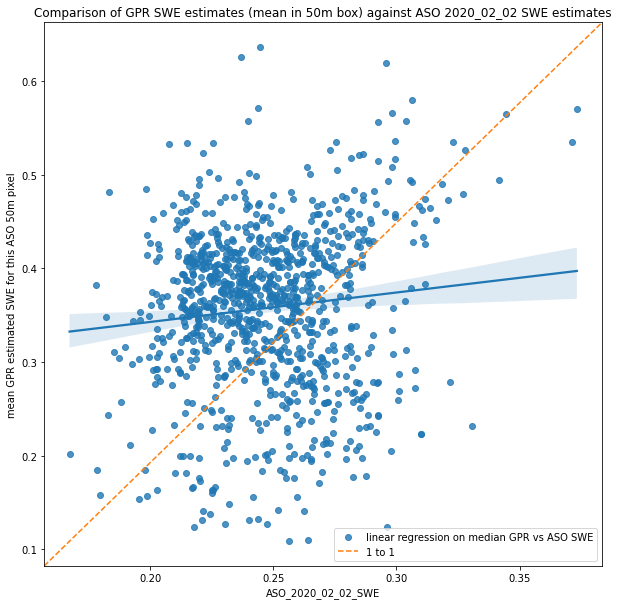

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
# df.groupby("ASO_2020_02_02_SWE", as_index=False).mean().plot(x="ASO_2020_02_02_SWE", kind="scatter", y="SWE", ax=ax)
sns.regplot(df_calc["ASO_2020_02_02_SWE"], df_calc["SWE"], label="linear regression on median GPR vs ASO SWE")
plt.ylabel("mean GPR estimated SWE for this ASO 50m pixel")
# plt.xlim(0)
# plt.ylim(0)
# ax.set_aspect("equal")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", label="1 to 1")
plt.title("Comparison of GPR SWE estimates (mean in 50m box) against ASO 2020_02_02 SWE estimates")
plt.legend()

In [23]:
# How to pull out ALL point data from the database that falls within our box
bbox_WSEN = 742000, 4322000, 747000, 4325000 # EPSG 26912?
x1, y1, x2, y2 = bbox_WSEN
polygon = shapely.geometry.Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]]) # used box() before
wkb_element = from_shape(polygon, srid=26912) # which srid is right?

/tmp/ipykernel_1046/3962914421.py:12: SAWarning: Class ST_Union will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  result = query.all()
/tmp/ipykernel_1046/3962914421.py:12: SAWarning: Class WKBElement will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternative

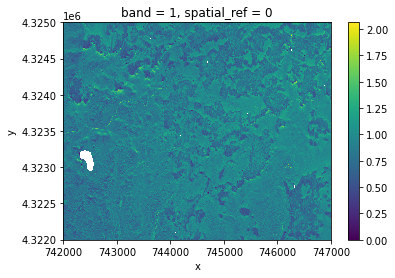

In [24]:
# Write our raster to disk
# Copy the profile/tiff metadata (not to be confused with the database metadata)

query = session.query(func.ST_AsTiff(func.ST_Clip(func.ST_Union(ImageData.raster, type_=Raster), wkb_element)))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.filter(ImageData.date == "2020-02-02")

# Filter the query by bounding box
query = query.filter(gfunc.ST_Intersects(ImageData.raster, wkb_element))

result = query.all()
aso_2020_02_02_rio = raster_to_rasterio(session, result)[0]
aso_2020_02_02_raster = aso_2020_02_02_rio.read(1, masked=True)

filename = "aso_2020_02_02_raster.tif"
with rasterio.open(filename, 'w', **aso_2020_02_02_rio.profile) as f:
    f.write(aso_2020_02_02_rio.read(1), 1)
ASO_snow = rioxarray.open_rasterio(filename, masked=True)
ASO_snow.plot()
# ASO_snow.hvplot.image(x='x', y='y', rasterize=True, cmap='bwr', clim=(-1,5),aspect=1/np.cos(np.deg2rad(latitude)))

## subtract the two SWE rasters and plot difference map

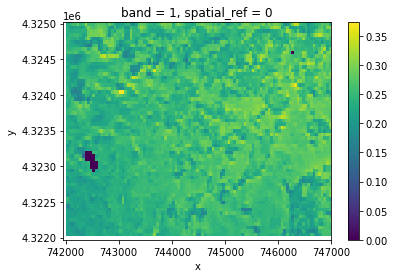

In [45]:
# Write our raster to disk
# Copy the profile/tiff metadata (not to be confused with the database metadata)

query = session.query(func.ST_AsTiff(func.ST_Clip(func.ST_Union(ImageData.raster, type_=Raster), wkb_element)))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "swe")
query = query.filter(ImageData.date == "2020-02-02")

# Filter the query by bounding box
query = query.filter(gfunc.ST_Intersects(ImageData.raster, wkb_element))

result = query.all()
aso_2020_02_02_swe_rio = raster_to_rasterio(session, result)[0]
aso_2020_02_02_swe_raster = aso_2020_02_02_swe_rio.read(1, masked=True)

filename = "aso_2020_02_02_swe_raster.tif"
with rasterio.open(filename, 'w', **aso_2020_02_02_swe_rio.profile) as f:
    f.write(aso_2020_02_02_swe_rio.read(1), 1)
ASO_2020_02_02_swe = rioxarray.open_rasterio(filename, masked=True)
ASO_2020_02_02_swe.plot()
# ASO_snow.hvplot.image(x='x', y='y', rasterize=True, cmap='bwr', clim=(-1,5),aspect=1/np.cos(np.deg2rad(latitude)))

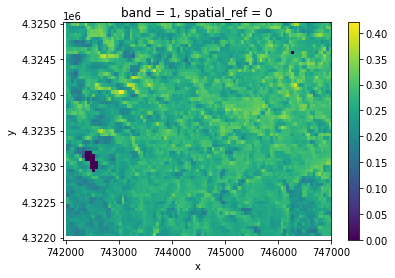

In [29]:
# Write our raster to disk
# Copy the profile/tiff metadata (not to be confused with the database metadata)

query = session.query(func.ST_AsTiff(func.ST_Clip(func.ST_Union(ImageData.raster, type_=Raster), wkb_element)))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "swe")
query = query.filter(ImageData.date == "2020-02-13")

# Filter the query by bounding box
query = query.filter(gfunc.ST_Intersects(ImageData.raster, wkb_element))

result = query.all()
aso_2020_02_13_swe_rio = raster_to_rasterio(session, result)[0]
aso_2020_02_13_swe_raster = aso_2020_02_13_swe_rio.read(1, masked=True)

filename = "aso_2020_02_13_swe_raster.tif"
with rasterio.open(filename, 'w', **aso_2020_02_13_swe_rio.profile) as f:
    f.write(aso_2020_02_13_swe_rio.read(1), 1)
ASO_2020_02_13_swe = rioxarray.open_rasterio(filename, masked=True)
ASO_2020_02_13_swe.plot()
# ASO_snow.hvplot.image(x='x', y='y', rasterize=True, cmap='bwr', clim=(-1,5),aspect=1/np.cos(np.deg2rad(latitude)))

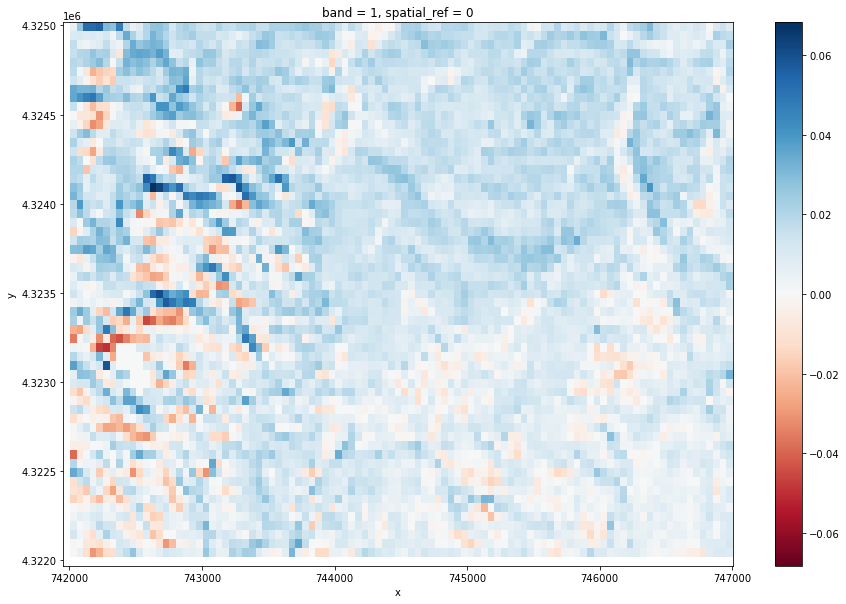

In [34]:
(ASO_2020_02_13_swe - ASO_2020_02_02_swe).plot(cmap="RdBu",figsize=(15,10))

In [35]:
rioxarray_copy_with_gpr_data = ASO_2020_02_02_swe.copy()

In [ ]:
gpr_fli

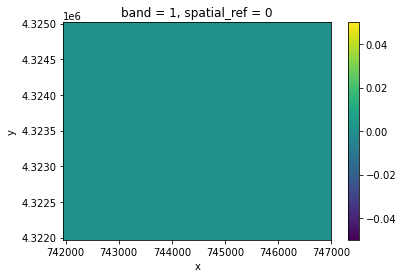

In [65]:
rioxarray_copy_with_gpr_data.data = np.zeros(ASO_2020_02_02_swe.shape)
rioxarray_copy_with_gpr_data.plot()

In [64]:
len(gdf_flight1)

40368

In [70]:
%%time
rioxarray_copy_with_gpr_data.data = np.zeros(ASO_2020_02_02_swe.shape)
for _,row in gdf_flight1.iterrows():
    # print(row)
    # print(row["ASO_X"], row["ASO_Y"], row["SWE"])
    # print(row["ASO_X"], type(row["ASO_X"]))
    idx = aso_2020_02_02_swe_rio.index(float(row["ASO_X"]), float(row["ASO_Y"])) # where this pixel is in the SWE raster
    # print(idx)
    ix,iy = idx
    try:
        swe = float(row["SWE"])
    except ValueError:
        swe = -9999999999999999
    rioxarray_copy_with_gpr_data.data[0,ix,iy] = swe

CPU times: user 2.74 s, sys: 0 ns, total: 2.74 s
Wall time: 2.74 s


In [89]:
rioxarray_copy_with_gpr_2 = ASO_2020_02_13_swe.copy()
rioxarray_copy_with_gpr_2.data = np.zeros(rioxarray_copy_with_gpr_2.shape)

In [90]:
%%time
gdf_flight2 = gpd.read_file("GPRLiDAR2.csv")
for _,row in gdf_flight2.iterrows():
    idx = aso_2020_02_13_swe_rio.index(float(row["ASO_X"]), float(row["ASO_Y"])) # where this pixel is in the SWE raster
    ix,iy = idx
    try:
        swe = float(row["SWE"])
    except ValueError:
        swe = -9999999999999999
    rioxarray_copy_with_gpr_2.data[0,ix,iy] = swe

CPU times: user 1.9 s, sys: 7.67 ms, total: 1.9 s
Wall time: 1.9 s


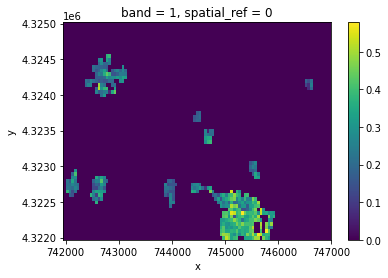

In [91]:
rioxarray_copy_with_gpr_2.plot()

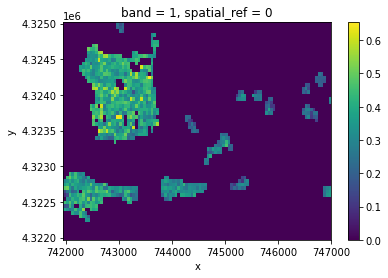

In [71]:
rioxarray_copy_with_gpr_data.plot()

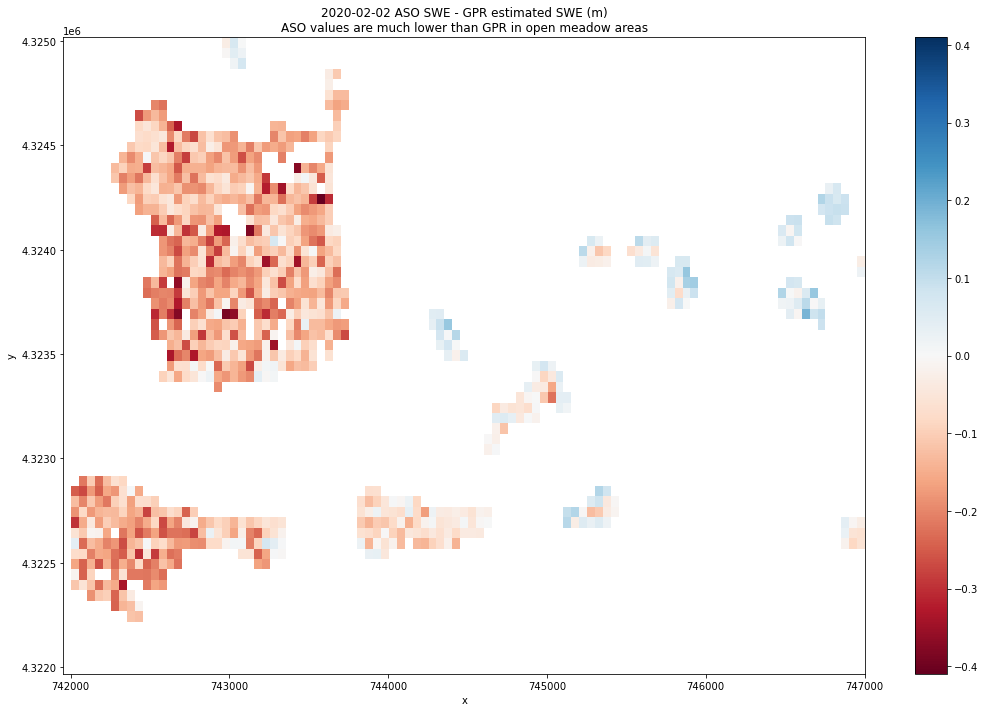

In [103]:
fig, ax = plt.subplots(figsize=(15,10))
(ASO_2020_02_02_swe - rioxarray_copy_with_gpr_data.where(rioxarray_copy_with_gpr_data > 0)).plot(cmap="RdBu", label="Difference in SWE (m)")
# Blue were small

# we can see here 
# need to do some more filtering
# this spatial relationship fits the theory
# density more homogenous than it actually is
#tree boundaries
plt.title("2020-02-02 ASO SWE - GPR estimated SWE (m)\nASO values are much lower than GPR in open meadow areas")

plt.tight_layout()

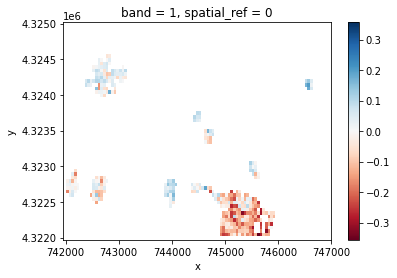

In [93]:

fig, ax = plt.subplots(figsize=(15,10))
(ASO_2020_02_13_swe - rioxarray_copy_with_gpr_2.where(rioxarray_copy_with_gpr_2 > 0)).plot(cmap="RdBu").plot(cmap="RdBu", label="Difference in SWE (m)")
# Blue were small

# we can see here 
# need to do some more filtering
# this spatial relationship fits the theory
# density more homogenous than it actually is
#tree boundaries
plt.title("2020-02-02 ASO SWE - GPR estimated SWE (m)\nASO values are much lower than GPR in open meadow areas")

plt.tight_layout()

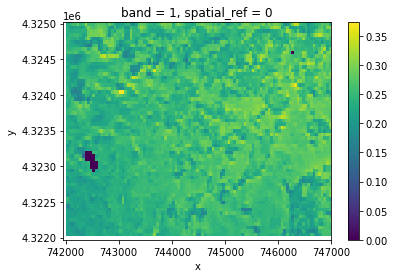

In [73]:
ASO_2020_02_02_swe.plot()

In [39]:
gdf_flight1["SWE"].head()

0     0.2526649191861511
1    0.24364769890614243
2    0.20721378198836704
3     0.2270636021509611
4    0.15978873712026012
Name: SWE, dtype: object